# Missing Person Heatmap – Combined Notebook
Quick walkthrough and cross-references for the merged notebooks.

## Summary
- Covers preprocessing, exploration, clustering (DBSCAN/KMeans), prediction models, spatial analysis, and gradient boosting.
- Uses Metro Manila missing person records; cleans data, engineers features, evaluates cluster quality, and compares predictors.
- Final sections generate spatial visualizations and 2025–2026 prediction outputs.

## Table of Contents
- [1. Preprocessing Workflow](#preprocessing-workflow)
- [2. Clustering Analysis](#clustering-analysis-for-missing-person-data)
- [3. Prediction Model Evaluation](#prediction-model-evaluation---2025-hotspot-forecasting)
- [4. Spatial Prediction](#spatial-prediction-notebook)
- [5. Gradient Boosting Prediction](#gradient-boosting-hotspot-modeling)

# **Preprocessing Workflow**
This notebook focuses on preparing the raw victim list for downstream analysis by loading source files, normalizing key text fields, enriching locations, and exporting a cleaned dataset.

In [12]:
import sys
import json
import unicodedata
import re
from pathlib import Path
from difflib import SequenceMatcher
import pandas as pd

# Ensure project modules are discoverable
project_root = (Path.cwd() / '..').resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Load Metro Manila location reference data
reference_path = project_root / 'data' / 'metro_manila_districts.json'
with reference_path.open(encoding='utf-8') as fh:
    metro_manila_reference = json.load(fh)

def normalize_text(value):
    if not isinstance(value, str):
        return ''
    normalized = unicodedata.normalize('NFKD', value)
    normalized = normalized.encode('ascii', 'ignore').decode('ascii')
    normalized = normalized.lower()
    normalized = re.sub(r'\bsta\.?\b', 'santa', normalized)
    normalized = re.sub(r'\bmla\b', 'manila', normalized)
    normalized = ''.join(ch if ch.isalnum() or ch.isspace() else ' ' for ch in normalized)
    normalized = normalized.replace('brgy', 'barangay')
    normalized = normalized.replace('barangays', 'barangay')
    return ' '.join(normalized.split())

BARANGAY_RANGE_RE = re.compile(r'^(?P<start>\d+)\s*(?:[-–]|to)\s*(?P<end>\d+)$')
CONNECTOR_SPLIT_RE = re.compile(r'\band\b|[,&/]', re.IGNORECASE)

def expand_barangay_entry(entry, fallback_coords):
    results = []
    if isinstance(entry, dict):
        name = (entry.get('name') or '').strip()
        coords = entry.get('coordinates', fallback_coords) or fallback_coords
        if name:
            results.append((name, coords))
        return results
    text = str(entry).strip()
    if not text:
        return results
    working = re.sub(r'(?i)brgys?', 'Barangay', text)
    working = re.sub(r'(?i)barangays?', 'Barangay', working)
    segments = [seg.strip() for seg in CONNECTOR_SPLIT_RE.split(working) if seg.strip()]
    if not segments:
        segments = [working.strip()]
    for segment in segments:
        segment = re.sub(r'(?i)^(barangay|brgy)\s*', '', segment)
        segment = segment.replace('.', ' ')
        segment = ' '.join(segment.split())
        if not segment:
            continue
        range_match = BARANGAY_RANGE_RE.match(segment)
        if range_match:
            start = int(range_match.group('start'))
            end = int(range_match.group('end'))
            if start <= end:
                for code in range(start, end + 1):
                    results.append((f'Barangay {code}', fallback_coords))
            continue
        if not re.match(r'^\d', segment):
            continue
        results.append((f'Barangay {segment.upper()}', fallback_coords))
    return results or [(text, fallback_coords)]

def build_location_lookup(reference):
    def safe_float(container, key):
        value = container.get(key) if isinstance(container, dict) else None
        return float(value) if isinstance(value, (int, float)) else None

    entries = []
    for city_entry in reference:
        city_name = city_entry.get('city', '')
        if not city_name:
            continue
        city_coords = city_entry.get('coordinates', {}) or {}
        city_aliases = {
            normalize_text(city_name),
            normalize_text(f'city of {city_name}'),
            normalize_text(f'{city_name} city')
        }
        entries.append({
            'city': city_name,
            'district': None,
            'barangay': None,
            'latitude': safe_float(city_coords, 'latitude'),
            'longitude': safe_float(city_coords, 'longitude'),
            'type': 'city',
            'aliases': {alias for alias in city_aliases if alias}
        })

        for district in city_entry.get('districts', []):
            district_name = district.get('name', '')
            if not district_name:
                continue
            district_coords = district.get('coordinates', city_coords) or {}
            district_aliases = {
                normalize_text(district_name),
                normalize_text(f'{district_name} {city_name}'),
                normalize_text(f'{city_name} {district_name}'),
            }
            if district.get('barangay_range'):
                district_aliases.add(normalize_text(district['barangay_range']))
            entries.append({
                'city': city_name,
                'district': district_name,
                'barangay': None,
                'latitude': safe_float(district_coords, 'latitude'),
                'longitude': safe_float(district_coords, 'longitude'),
                'type': 'district',
                'aliases': {alias for alias in district_aliases if alias},
            })

            barangay_sources = []
            if isinstance(district.get('barangays'), list):
                barangay_sources.extend(district['barangays'])
            if isinstance(district.get('barangay_list'), list):
                barangay_sources.extend(district['barangay_list'])

            seen_barangays = set()
            for barangay_entry in barangay_sources:
                for barangay_name, barangay_coords in expand_barangay_entry(barangay_entry, district_coords):
                    canonical_name = barangay_name.strip()
                    if not canonical_name:
                        continue
                    key = canonical_name.lower()
                    if key in seen_barangays:
                        continue
                    seen_barangays.add(key)
                    alias_candidates = {
                        normalize_text(canonical_name),
                        normalize_text(f'{canonical_name} {district_name}'),
                        normalize_text(f'{canonical_name} {city_name}'),
                    }
                    number_token = canonical_name.replace('Barangay', '').strip()
                    if number_token:
                        alias_candidates.update({
                            normalize_text(f'barangay {number_token}'),
                            normalize_text(f'brgy {number_token}'),
                            normalize_text(number_token),
                            normalize_text(f'{number_token} {district_name}'),
                            normalize_text(f'{number_token} {city_name}'),
                        })
                    entries.append({
                        'city': city_name,
                        'district': district_name,
                        'barangay': canonical_name,
                        'latitude': safe_float(barangay_coords, 'latitude'),
                        'longitude': safe_float(barangay_coords, 'longitude'),
                        'type': 'barangay',
                        'aliases': {alias for alias in alias_candidates if alias}
                    })

    priority_order = {'barangay': 0, 'district': 1, 'city': 2}
    entries.sort(key=lambda entry: priority_order.get(entry['type'], 3))
    return entries

location_lookup = build_location_lookup(metro_manila_reference)

# Precompute Manila district aliases for fast lookups on tail phrases
manila_district_aliases = {}
for entry in location_lookup:
    if entry['city'].lower() == 'manila' and entry['type'] == 'district':
        for alias in entry['aliases']:
            if alias:
                manila_district_aliases[alias] = entry

# Strong keyword → district priority for Manila (cover all 16)
MANILA_PRIORITY = [
    ('tondo', 'Tondo'),
    ('sampaloc', 'Sampaloc'),
    ('san miguel', 'San Miguel'),
    ('san nicolas', 'San Nicolas'),
    ('sta nicolas', 'San Nicolas'),
    ('malate', 'Malate'),
    ('ermita', 'Ermita'),
    ('quiapo', 'Quiapo'),
    ('intramuros', 'Intramuros'),
    ('pandacan', 'Pandacan'),
    ('paco', 'Paco'),
    ('port area', 'Port Area'),
    ('san andres', 'San Andres'),
    ('santa cruz', 'Santa Cruz'),
    ('sta cruz', 'Santa Cruz'),
    ('santa mesa', 'Santa Mesa'),
    ('sta mesa', 'Santa Mesa'),
    ('santa ana', 'Santa Ana'),
    ('sta ana', 'Santa Ana'),
    ('binondo', 'Binondo')
 ]

special_locations = [
    {
        'aliases': {
            'manila arena',
            'rizal memorial coliseum',
            'rizal memorial sports complex'
        },
        'result': {
            'city': 'Manila',
            'district': 'Malate',
            'barangay': None,
            'latitude': 14.562222,
            'longitude': 120.993889,
            'type': 'barangay',
            'match_score': 1.0
        }
    }
 ]

def match_location_metadata(raw_location):
    norm_location = normalize_text(raw_location)
    if not norm_location:
        return None

    # Treat any Manila district keyword as a Manila hint, even without the word "Manila"
    manila_keyword = any(token in norm_location for token, _ in MANILA_PRIORITY)
    manila_hint = 'manila' in norm_location or 'metro manila' in norm_location or manila_keyword

    # Heuristic: look at the last 1-2 comma-separated parts to catch patterns like "... Tondo, Manila"
    tail_parts = [p.strip() for p in str(raw_location).split(',') if p and str(p).strip()]
    tail_phrases = []
    if tail_parts:
        tail_phrases.append(normalize_text(' '.join(tail_parts[-2:])))
        tail_phrases.append(normalize_text(tail_parts[-1]))
    tail_phrases = [p for p in tail_phrases if p]

    for special in special_locations:
        if any(alias in norm_location for alias in special['aliases']):
            return special['result'].copy()

    def lookup_manila_district(name):
        for entry in location_lookup:
            if entry['city'].lower() == 'manila' and entry['type'] == 'district' and entry['district'].lower() == name.lower():
                return entry
        return None

    # Priority: exact keyword hits for Manila districts
    if manila_hint:
        for token, district_name in MANILA_PRIORITY:
            if token in norm_location or any(token in phrase for phrase in tail_phrases):
                entry = lookup_manila_district(district_name)
                if entry:
                    result = entry.copy()
                    result['match_score'] = 0.95
                    return result

    # Try tail phrases and overall text against Manila district aliases first
    if manila_hint:
        for alias, entry in manila_district_aliases.items():
            if not alias:
                continue
            if alias in norm_location or any(alias in phrase or phrase in alias for phrase in tail_phrases):
                result = entry.copy()
                result['match_score'] = 0.9
                return result

    # Try tail phrases against district/barangay aliases for Manila
    if manila_hint:
        for entry in location_lookup:
            if entry['city'].lower() != 'manila':
                continue
            if entry['type'] not in ('district', 'barangay'):
                continue
            for phrase in tail_phrases:
                if phrase in entry['aliases'] or any(alias in phrase for alias in entry['aliases']):
                    result = entry.copy()
                    result['match_score'] = 0.85
                    return result

    best_scores = {
        'barangay': (None, 0.0),
        'district': (None, 0.0),
        'city': (None, 0.0)
    }

    for entry in location_lookup:
        if manila_hint and entry['city'].lower() != 'manila':
            continue
        entry_type = entry['type']
        for alias in entry['aliases']:
            if not alias:
                continue
            if alias in norm_location:
                score = 1.0
            else:
                score = SequenceMatcher(None, alias, norm_location).ratio()
            stored_entry, stored_score = best_scores.get(entry_type, (None, 0.0))
            if score > stored_score:
                best_scores[entry_type] = (entry, score)

    thresholds = {'barangay': 0.7, 'district': 0.55, 'city': 0.55}
    for entry_type in ('barangay', 'district', 'city'):
        entry, score = best_scores.get(entry_type, (None, 0.0))
        if entry and score >= thresholds[entry_type]:
            result = entry.copy()
            result['match_score'] = round(score, 3)
            return result

    city_entry, city_score = best_scores.get('city', (None, 0.0))
    district_entry, district_score = best_scores.get('district', (None, 0.0))
    if manila_hint:
        template = city_entry or district_entry
        result = (template or {
            'city': 'Manila',
            'district': None,
            'barangay': None,
            'latitude': None,
            'longitude': None,
            'type': 'city'
        }).copy()
        result['city'] = 'Manila'
        if district_entry and (district_entry['district'].lower() in norm_location or any(district_entry['district'].lower() in phrase for phrase in tail_phrases)):
            result['district'] = district_entry.get('district')
            result['latitude'] = district_entry.get('latitude')
            result['longitude'] = district_entry.get('longitude')
            result['type'] = 'district'
            score = max(district_score, 0.55)
        else:
            score = max(city_score, 0.55)
        result['match_score'] = round(score, 3)
        return result

    fallback_entry = None
    fallback_score = 0.0
    fallback_threshold = 0.4
    for entry_type in ('district', 'city'):
        entry, score = best_scores.get(entry_type, (None, 0.0))
        if entry and score > fallback_score and score >= fallback_threshold:
            fallback_entry = entry
            fallback_score = score
    if fallback_entry:
        result = fallback_entry.copy()
        result['match_score'] = round(fallback_score, 3)
        return result

    return None

# 1. Load Data
df = pd.read_csv("../dataset/Manila_City_Only_List.csv")

# 2. Missing Value Analysis
# We need to count both standard NaNs and text "na"
missing_counts = {}
for col in df.columns:
    nan_count = df[col].isnull().sum()
    # Check for "na" string if column is text
    if df[col].dtype == 'object':
        na_str_count = df[col].astype(str).str.strip().str.lower().eq('na').sum()
    else:
        na_str_count = 0
    missing_counts[col] = nan_count + na_str_count

df.head(5)

,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Longtitude,Latitude,Post URL
0,NaN,59,male,1/14/2020,12:48 PM,12/14/2019,"Malate, Manila",NaN,NaN,https://www.facebook.com/share/p/1Fp5H7uddW/
1,NaN,41,Male,01/24/2020,5:12 PM,01/16/2021,"Sampaloc, Manila",NaN,NaN,https://www.facebook.com/share/p/1CwZW3pbpf/
2,NaN,43,Male,2/9/2020,7:03 PM,NaN,"Tondo, Manila",NaN,NaN,https://www.facebook.com/share/p/1CoiXoTEjb/
3,NaN,14,Male,2/15/2020,12:19 PM,na,"Binondo, Manila",NaN,NaN,https://www.facebook.com/share/p/17Umn23xj9/
4,NaN,16,male,03/23/2020,12:25,03/11/2025,"Paco,. Manila",NaN,NaN,https://www.facebook.com/share/p/1BhMzYvEJN/


### Import & Missing Value Audit
- Loads the Metro Manila reference, builds a lookup, and defines the normalization helper.
- Reads the raw CSV and tallies missing markers (`NaN` and literal `"na"`).
- Shows the head of the dataset so we can sanity-check columns before cleaning.

In [13]:
# Calculate total percentage empty
total_cells = df.size
total_missing = sum(missing_counts.values())
percent_empty = (total_missing / total_cells) * 100

print(f"Total Dataset Empty: {percent_empty:.2f}%")
print("Missing Counts per Column:")

missing_df = pd.DataFrame(list(missing_counts.items()), columns=['Column', 'Missing Count'])
missing_df.sort_values(by='Missing Count', ascending=False)

Total Dataset Empty: 35.31%
Missing Counts per Column:


,Column,Missing Count
0,Person ID,113
7,Longtitude,113
8,Latitude,113
5,Date Last Seen,54
4,Time Reported Missing,5
9,Post URL,1
1,AGE,0
2,GENDER,0
3,Date Reported Missing,0
6,Location Last Seen,0


## **Data Preprocessing**
We streamline columns, standardize categorical fields, and convert date/time text into structured formats so downstream analyses operate on clean data.

In [14]:
# 1. Drop Irrelevant Columns
df_clean = df.drop(columns=['Latitude', 'Longtitude'])

In [15]:
# 2. Standardize Demographics
# Clean Gender (remove spaces, capitalize)
df_clean['GENDER'] = df_clean['GENDER'].str.strip().str.capitalize()

In [16]:
# 3. Parse Dates & Times
# Convert Date columns
df_clean['Date Reported Missing'] = pd.to_datetime(df_clean['Date Reported Missing'], errors='coerce')

In [17]:
# Handle 'na' in Date Last Seen before converting
df_clean['Date Last Seen'] = df_clean['Date Last Seen'].replace('na', pd.NA)
df_clean['Date Last Seen'] = pd.to_datetime(df_clean['Date Last Seen'], errors='coerce')

# Clean Time: Handle 'na' and convert mixed formats (12h/24h)
df_clean['Time Reported Missing'] = df_clean['Time Reported Missing'].replace('na', pd.NA)
# The datetime converter infers the correct format automatically
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_92897/1347800615.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


In [18]:
df_clean.head(5)

,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj
0,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00
1,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00
2,NaN,43,Male,2020-02-09,7:03 PM,NaT,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00
3,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00
4,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00


## **Age Binning**
Custom logic clusters numeric ages and free-text descriptors into consistent life-stage buckets for clearer demographic charts.

In [19]:
def smart_bin_age(val):
    s_val = str(val).lower().strip()
    if s_val == 'adult': return 'Adult'
    elif s_val in ['senior', 'adult older']: return 'Old'
    elif s_val == 'teen': return 'Teen'
    elif s_val == 'young teen': return 'Young Teen'
    elif s_val == 'young adult': return 'Young Adult'
    elif s_val == 'child': return 'Child'

    try:
        age_num = float(val)
        if pd.isna(age_num): return "Unknown"
        if age_num < 13: return "Child"
        elif 13 <= age_num <= 14: return "Young Teen"
        elif 15 <= age_num <= 17: return "Teen"
        elif 18 <= age_num <= 24: return "Young Adult"
        elif 25 <= age_num <= 59: return "Adult"
        else: return "Old"
    except:
        return "Unknown"

In [20]:
# Apply Logic
df_clean['Age_Group'] = df_clean['AGE'].apply(smart_bin_age)
df_clean['Age_Group'].value_counts(dropna=False)

Age_Group
Adult          50
Old            22
Young Teen     11
Young Adult    11
Teen           10
Child           9
Name: count, dtype: int64

## **City - Barangay Segregation**
Using the JSON lookup we match each record to a Metro Manila city or district, capture coordinates, and flag the confidence level for mapping.

In [21]:
# Derive Metro Manila city/district metadata & coordinates
location_matches = df_clean['Location Last Seen'].apply(match_location_metadata)

def format_city_label(match):
    if not match:
        return "Other/Unknown"
    city_name = match['city'].strip().lower()
    return "Manila City" if city_name == 'manila' else match['city']

df_clean['City_Cleaned'] = location_matches.apply(format_city_label)
df_clean['Barangay_Cleaned'] = location_matches.apply(
    lambda match: match['barangay'] if match and match.get('barangay') else pd.NA
)
df_clean['District_Cleaned'] = location_matches.apply(
    lambda match: match['district'] if match and match.get('district') else pd.NA
)
df_clean['Latitude'] = location_matches.apply(
    lambda match: match['latitude'] if match and match.get('latitude') is not None else pd.NA
)
df_clean['Longitude'] = location_matches.apply(
    lambda match: match['longitude'] if match and match.get('longitude') is not None else pd.NA
)
df_clean['Location_Match_Level'] = location_matches.apply(
    lambda match: match['type'] if match else "none"
)
df_clean['Location_Match_Score'] = location_matches.apply(
    lambda match: match['match_score'] if match and match.get('match_score') is not None else pd.NA
)

# 3. Clean Date & Time
df_clean['Date Reported Missing'] = pd.to_datetime(df['Date Reported Missing'], errors='coerce')
df_clean['Year'] = df_clean['Date Reported Missing'].dt.year

df_clean['Time Reported Missing'] = df_clean['Time Reported Missing'].replace('na', pd.NA)
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')
df_clean['Hour_Missing'] = df_clean['Time_Obj'].dt.hour

# Drop records with missing reported dates (cannot be used downstream)
df_clean = df_clean.dropna(subset=['Date Reported Missing'])

# Ensure deterministic IDs before export
df_clean = df_clean.reset_index(drop=True)
df_clean.insert(0, 'Person_ID', [f"MP-{i:04d}" for i in range(1, len(df_clean) + 1)])

export_columns = [col for col in df_clean.columns if True]
df_clean.to_csv("Missing People - cleaned.csv", index=False, columns=export_columns)

del location_matches

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_92897/2906318626.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


In [22]:
df_clean.head(5)

,Person_ID,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,Age_Group,City_Cleaned,Barangay_Cleaned,District_Cleaned,Latitude,Longitude,Location_Match_Level,Location_Match_Score,Year,Hour_Missing
0,MP-0001,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00,Adult,Manila City,<NA>,Malate,14.5714,120.9904,district,0.95,2020.0,12.0
1,MP-0002,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00,Adult,Manila City,<NA>,Sampaloc,14.6133,121.0003,district,0.95,2020.0,17.0
2,MP-0003,NaN,43,Male,2020-02-09,7:03 PM,NaT,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00,Adult,Manila City,<NA>,Tondo,14.6186,120.9681,district,0.95,2020.0,19.0
3,MP-0004,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00,Young Teen,Manila City,<NA>,Binondo,14.6006,120.9754,district,0.95,2020.0,12.0
4,MP-0005,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00,Teen,Manila City,<NA>,Paco,14.5833,120.9961,district,0.95,2020.0,12.0


### Setup
Import plotting dependencies, load the raw CSV for data-quality checks, and read the cleaned output for downstream visuals.

In [19]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

project_root = (Path.cwd() / '..').resolve()
raw_path = project_root / 'dataset' / 'Manila_City_Only_List.csv'
clean_path = Path('Missing People - cleaned.csv')
output_dir = Path('outputs')
output_dir.mkdir(parents=True, exist_ok=True)

df_raw = pd.read_csv(raw_path)

if not clean_path.exists():
    raise FileNotFoundError("Run 01_data_preprocessing.ipynb first to generate 'Missing People - cleaned.csv'.")

df_clean = pd.read_csv(clean_path)
df_clean['Date Reported Missing'] = pd.to_datetime(df_clean['Date Reported Missing'], errors='coerce')
df_clean['Date Last Seen'] = pd.to_datetime(df_clean['Date Last Seen'], errors='coerce')
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')
df_clean['Hour_Missing'] = pd.to_numeric(df_clean['Hour_Missing'], errors='coerce')
df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')

df_clean.head()

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_21909/2100016670.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


,Person_ID,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,Age_Group,City_Cleaned,Barangay_Cleaned,District_Cleaned,Latitude,Longitude,Location_Match_Level,Location_Match_Score,Year,Hour_Missing
0,MP-0001,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00,Adult,Manila City,NaN,Malate,14.5714,120.9904,district,0.95,2020.0,12.0
1,MP-0002,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00,Adult,Manila City,NaN,Sampaloc,14.6133,121.0003,district,0.95,2020.0,17.0
2,MP-0003,NaN,43,Male,2020-02-09,7:03 PM,NaT,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00,Adult,Manila City,NaN,Tondo,14.6186,120.9681,district,0.95,2020.0,19.0
3,MP-0004,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00,Young Teen,Manila City,NaN,Binondo,14.6006,120.9754,district,0.95,2020.0,12.0
4,MP-0005,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00,Teen,Manila City,NaN,Paco,14.5833,120.9961,district,0.95,2020.0,12.0


### Missing Value Overview
Counts nulls and literal `"na"` entries per column, then plots the worst offenders.

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_21909/595098432.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r', ax=ax)


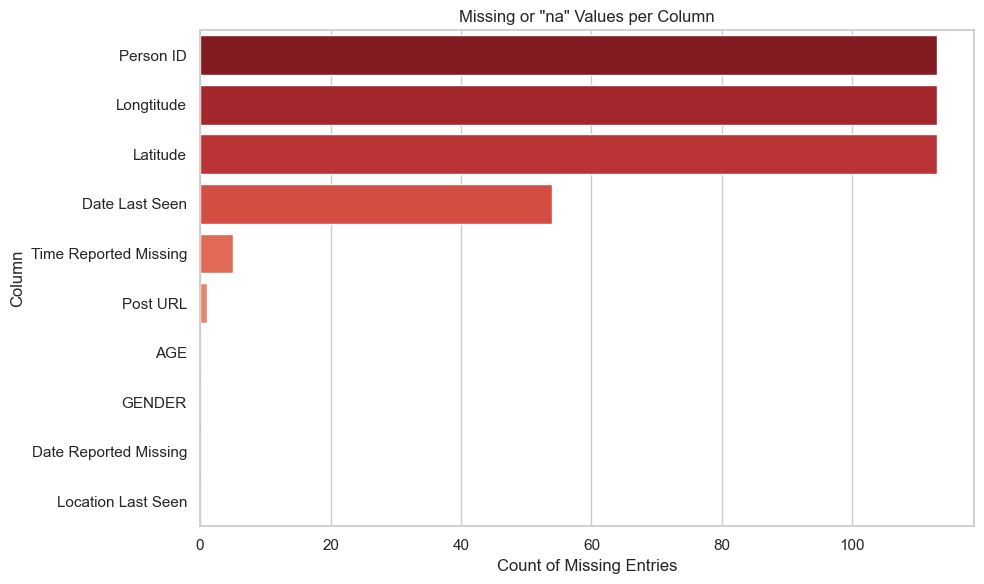

,Column,Missing Count
0,Person ID,113
7,Longtitude,113
8,Latitude,113
5,Date Last Seen,54
4,Time Reported Missing,5
9,Post URL,1
1,AGE,0
2,GENDER,0
3,Date Reported Missing,0
6,Location Last Seen,0


In [20]:
missing_counts = {}
for col in df_raw.columns:
    nan_count = df_raw[col].isnull().sum()
    if df_raw[col].dtype == 'object':
        na_str_count = df_raw[col].astype(str).str.strip().str.lower().eq('na').sum()
    else:
        na_str_count = 0
    missing_counts[col] = nan_count + na_str_count

missing_df = (
    pd.DataFrame(list(missing_counts.items()), columns=['Column', 'Missing Count'])
      .sort_values(by='Missing Count', ascending=False)
 )

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r', ax=ax)
ax.set_title('Missing or "na" Values per Column')
ax.set_xlabel('Count of Missing Entries')
fig.tight_layout()
fig.savefig(output_dir / 'missing_values_bar.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

missing_df

### Age Distribution
Visualizes the smart age bins introduced during preprocessing.

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_21909/811815467.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis', ax=ax)


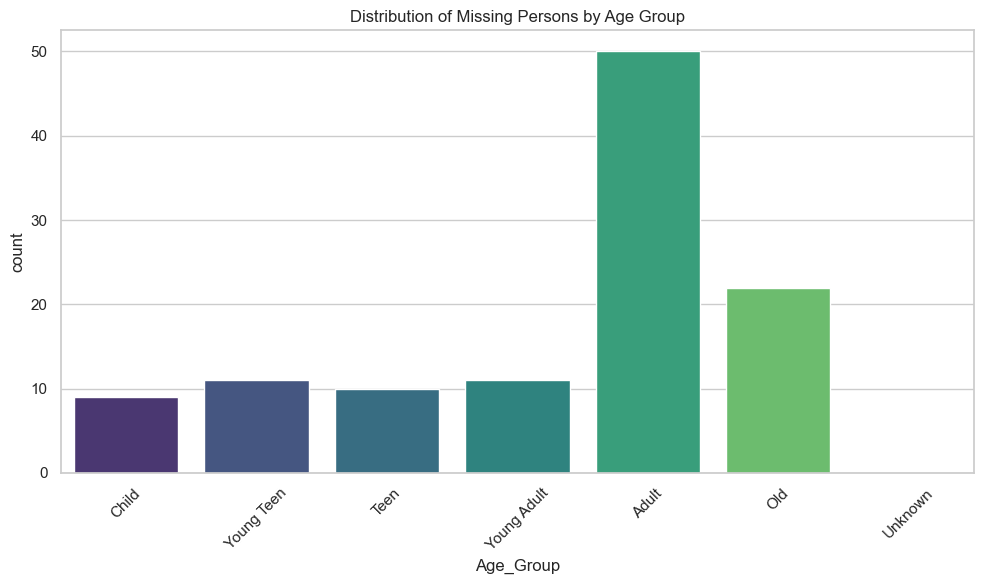

In [21]:
order = ['Child', 'Young Teen', 'Teen', 'Young Adult', 'Adult', 'Old']
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')
plt.title('Distribution of Missing Persons by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Hourly Pattern
Highlights peak reporting times using the derived `Hour_Missing` feature.

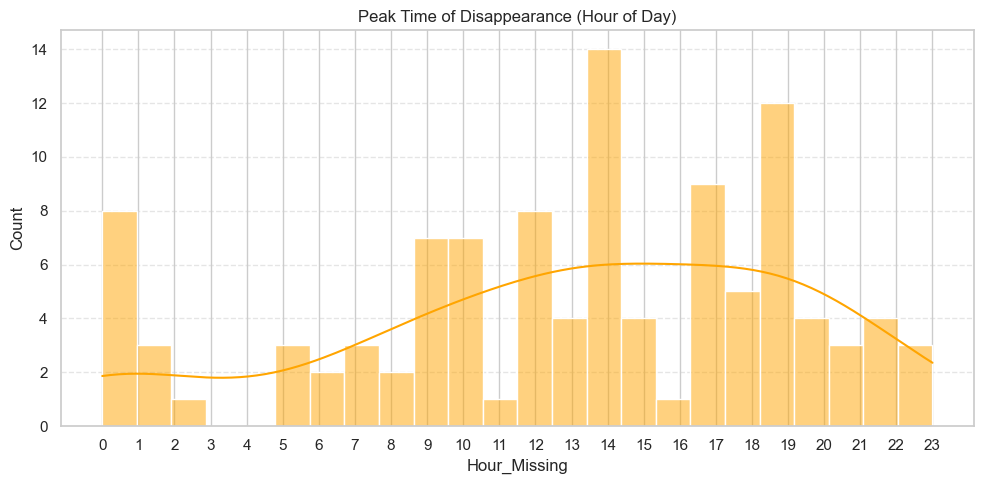

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df_clean, x='Hour_Missing', bins=24, kde=True, color='orange', ax=ax)
ax.set_title('Peak Time of Disappearance (Hour of Day)')
ax.set_xticks(range(0, 24))
ax.grid(axis='y', linestyle='--', alpha=0.5)
fig.tight_layout()
fig.savefig(output_dir / 'hourly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

### Location Completeness
Checks how often `Location Last Seen` is populated after cleaning.

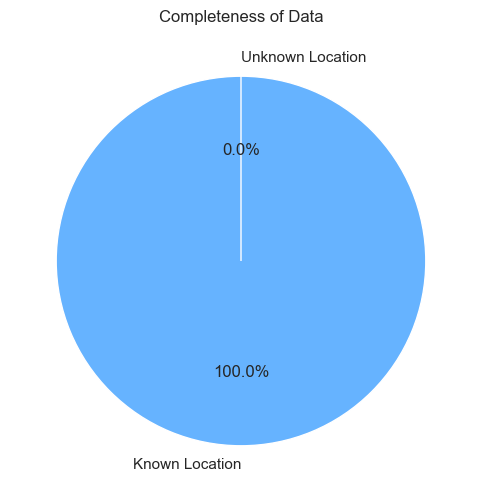

In [23]:
missing_loc_count = df_clean['Location Last Seen'].isnull().sum() + \
                    (df_clean['Location Last Seen'].astype(str).str.lower() == 'na').sum()
present_loc_count = len(df_clean) - missing_loc_count

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    [present_loc_count, missing_loc_count],
    labels=['Known Location', 'Unknown Location'],
    autopct='%1.1f%%',
    colors=['#66b3ff', '#ff9999'],
    startangle=90
 )
ax.set_title('Completeness of Data')
fig.savefig(output_dir / 'location_completeness_pie.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

### Seasonal Pattern
Polar chart to inspect month-by-month variation in reports.

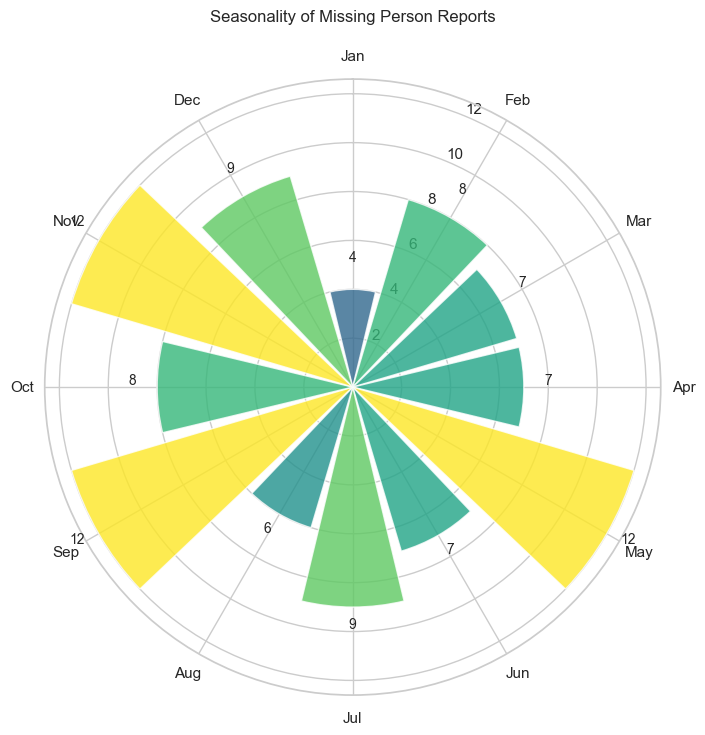

In [24]:
df_dates = df_clean.dropna(subset=['Date Reported Missing']).copy()
df_dates['Month'] = df_dates['Date Reported Missing'].dt.month
monthly_counts = df_dates['Month'].value_counts().sort_index()
for m in range(1, 13):
    if m not in monthly_counts:
        monthly_counts[m] = 0
monthly_counts = monthly_counts.sort_index()

theta = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
width = (2 * np.pi) / 12 * 0.9

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

bars = ax.bar(
    theta,
    monthly_counts.values,
    width=width,
    bottom=0.0,
    alpha=0.8,
    color=plt.cm.viridis(monthly_counts.values / max(monthly_counts.values) if max(monthly_counts.values) else 1)
 )

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(theta)
ax.set_xticklabels(month_labels)

for bar, angle, count in zip(bars, theta, monthly_counts.values):
    ax.text(angle, bar.get_height() + 1, str(count), ha='center', va='bottom', fontsize=10)

ax.set_title('Seasonality of Missing Person Reports', y=1.08)
fig.savefig(output_dir / 'seasonality_polar_plot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

### Timeline
Monthly counts across the entire observation window.

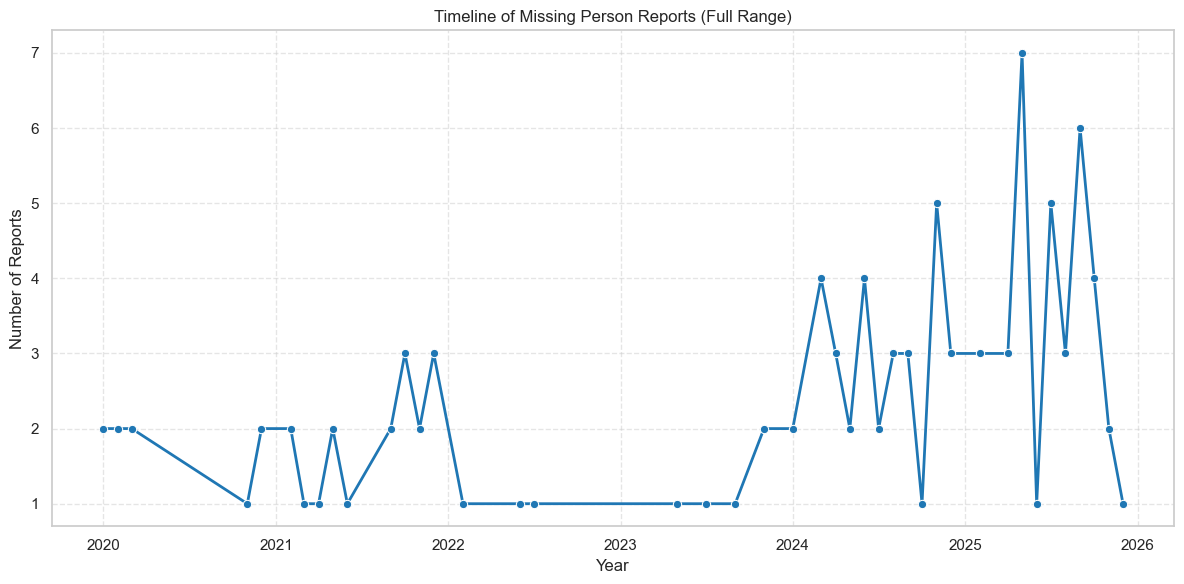

In [25]:
monthly_counts = df_clean.groupby(df_clean['Date Reported Missing'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o', color='#1f77b4', linewidth=2, ax=ax)
ax.set_title('Timeline of Missing Person Reports (Full Range)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Reports')
ax.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
fig.savefig(output_dir / 'monthly_timeline.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

### Metro Manila City Comparison
Shows annual case counts per Metro Manila city based on the cleaned location labels.

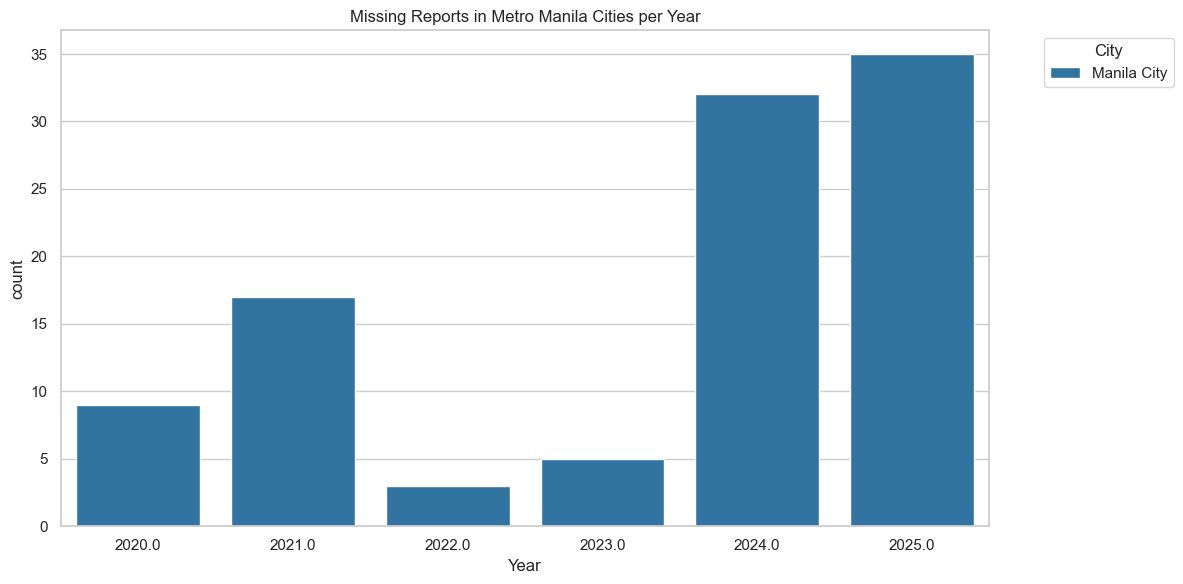

Total number of Metro Manila cases from 2020-2025: 101


In [26]:
df_mm = df_clean[df_clean['City_Cleaned'] != 'Other/Unknown'].dropna(subset=['Year']).copy()
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df_mm, x='Year', hue='City_Cleaned', palette='tab20', ax=ax)
ax.set_title('Missing Reports in Metro Manila Cities per Year')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='City')
fig.tight_layout()
fig.savefig(output_dir / 'metro_manila_city_counts.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

cases_2020_2025 = df_mm[(df_mm['Year'] >= 2020) & (df_mm['Year'] <= 2025)].shape[0]
print(f'Total number of Metro Manila cases from 2020-2025: {cases_2020_2025}')

### District Distribution
Breaks down the cleaned Manila cases by matched district to highlight hotspots after fuzzy matching.

/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_21909/1971564704.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=display_df, y='District_Cleaned', x='Count', palette='mako', ax=ax)


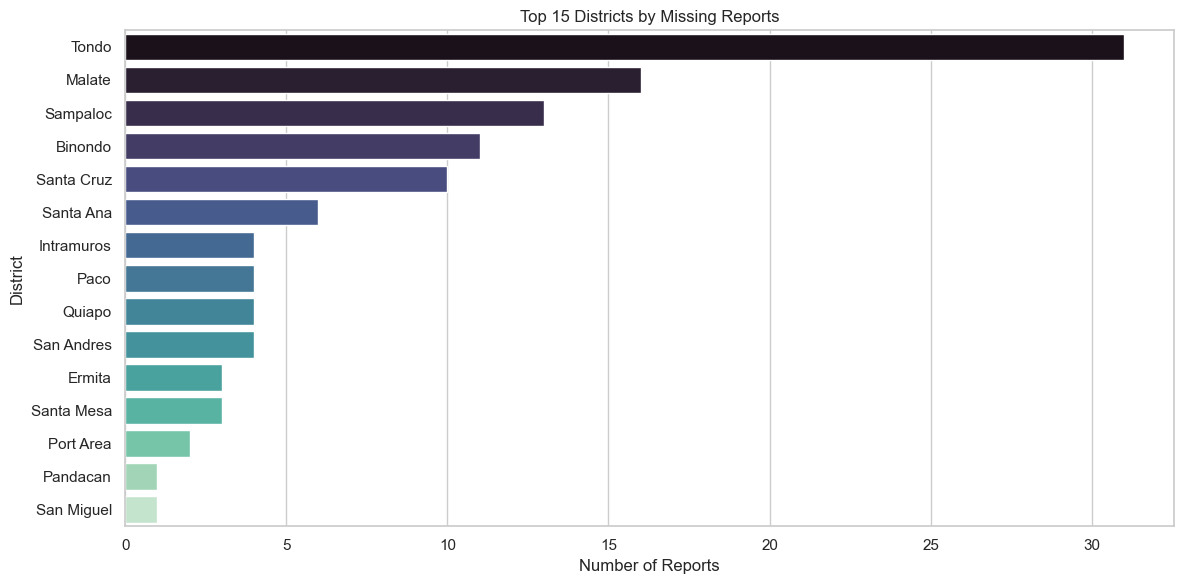

,District_Cleaned,Count
0,Tondo,31
1,Malate,16
2,Sampaloc,13
3,Binondo,11
4,Santa Cruz,10
5,Santa Ana,6
6,Intramuros,4
7,Paco,4
8,Quiapo,4
9,San Andres,4


In [27]:
district_counts = (
    df_clean[df_clean['District_Cleaned'].notna()]
    .groupby('District_Cleaned')
    .size()
    .sort_values(ascending=False)
 )

top_n = 20
display_df = district_counts.head(top_n).rename('Count').reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=display_df, y='District_Cleaned', x='Count', palette='mako', ax=ax)
ax.set_title(f'Top {min(top_n, len(display_df))} Districts by Missing Reports')
ax.set_xlabel('Number of Reports')
ax.set_ylabel('District')
fig.tight_layout()
fig.savefig(output_dir / 'top_districts_bar.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

if len(district_counts) > top_n:
    print(f"Remaining {len(district_counts) - top_n} districts grouped into 'Other'.")
display_df

# Clustering Analysis for Missing Person Data
This notebook consumes the cleaned export (`Missing People - cleaned.csv`) generated by the preprocessing workflow and performs two clustering studies: geographic hotspots based on coordinates and demographic groupings using age/gender information.

In [11]:
import sys
from pathlib import Path

# Add parent directory to path so src module can be found
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import LabelEncoder
import folium
from IPython.display import display, HTML

from src.core.analysis.clustering import ClusteringModel

sns.set_theme(style='whitegrid')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
DATA_PATH = Path('Missing People - cleaned.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(
        "Run 01_data_preprocessing.ipynb first to regenerate 'Missing People - cleaned.csv'."
    )

processed_df = pd.read_csv(DATA_PATH)

processed_df['Latitude'] = pd.to_numeric(processed_df['Latitude'], errors='coerce')
processed_df['Longitude'] = pd.to_numeric(processed_df['Longitude'], errors='coerce')

processed_df['Gender'] = processed_df['GENDER'].astype(str).str.strip().str.capitalize()
processed_df['Gender'] = processed_df['Gender'].replace({'Nan': pd.NA, '': pd.NA, 'Na': pd.NA})

processed_df['District_Cleaned'] = processed_df['District_Cleaned'].fillna('Unknown')
processed_df['City_Cleaned'] = processed_df['City_Cleaned'].fillna('Other/Unknown')

processed_df['Age'] = pd.to_numeric(processed_df['AGE'], errors='coerce')
if 'Age_Group' in processed_df.columns:
    processed_df['Age_Group'] = processed_df['Age_Group'].fillna('Unknown')
else:
    processed_df['Age_Group'] = 'Unknown'

processed_df = processed_df.drop_duplicates(subset=['Person_ID']).reset_index(drop=True)
processed_df.head(5)

,Person_ID,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,...,Barangay_Cleaned,District_Cleaned,Latitude,Longitude,Location_Match_Level,Location_Match_Score,Year,Hour_Missing,Gender,Age
0,MP-0001,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00,...,NaN,Malate,14.5714,120.9904,district,0.95,2020.0,12.0,Male,59.0
1,MP-0002,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00,...,NaN,Sampaloc,14.6133,121.0003,district,0.95,2020.0,17.0,Male,41.0
2,MP-0003,NaN,43,Male,2020-02-09,7:03 PM,NaN,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00,...,NaN,Tondo,14.6186,120.9681,district,0.95,2020.0,19.0,Male,43.0
3,MP-0004,NaN,14,Male,2020-02-15,12:19 PM,NaN,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00,...,NaN,Binondo,14.6006,120.9754,district,0.95,2020.0,12.0,Male,14.0
4,MP-0005,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00,...,NaN,Paco,14.5833,120.9961,district,0.95,2020.0,12.0,Male,16.0


In [ ]:
demo_df = processed_df[['Person_ID', 'Age', 'Gender']].dropna(subset=['Age'])
demo_df['Gender'] = demo_df['Gender'].fillna('Unknown')

gender_encoder = LabelEncoder()
demo_df['Gender_Code'] = gender_encoder.fit_transform(demo_df['Gender'])
demo_df.head()

## Demographic Clustering (Age + Gender)
We cluster by demographic features to identify groups with similar age/gender patterns. We encode gender into numeric form for clustering while keeping the original labels for interpretation.

In [ ]:
k_sweep_model = ClusteringModel()
k_results = k_sweep_model.find_optimal_k(
    demo_df,
    k_range=(2, 6),
    features=['Age', 'Gender_Code']
 )
k_metrics = (
    pd.DataFrame.from_dict(k_results, orient='index')
      .rename_axis('k')
      .reset_index()
)
k_metrics = k_metrics.sort_values(by='silhouette_score', ascending=False)
best_k = int(k_metrics.iloc[0]['k'])
display(k_metrics)
print(f"Selected K-means cluster count: k={best_k}")

✓ Evaluated K-means for k=2 to k=6


,k,inertia,silhouette_score,davies_bouldin_score
4,6,5.135147,0.641585,0.401381
3,5,7.374804,0.637739,0.429334
2,4,14.404219,0.635690,0.452734
1,3,25.966202,0.590565,0.566126
0,2,53.857922,0.557973,0.755489


Selected K-means cluster count: k=6


In [ ]:
demo_model = ClusteringModel()
demo_model.fit_kmeans(
    demo_df,
    n_clusters=best_k,
    features=['Age', 'Gender_Code']
 )
demo_clustered = demo_model.add_cluster_labels(demo_df)
demo_clustered.head()

✓ K-means clustering complete: 6 clusters identified


,Person_ID,Age,Gender,Age_Group,Gender_Code,Cluster
0,MP-0001,59.0,Male,Adult,1,1
1,MP-0002,41.0,Male,Adult,1,2
2,MP-0003,43.0,Male,Adult,1,2
3,MP-0004,14.0,Male,Young Teen,1,4
4,MP-0005,16.0,Male,Teen,1,4


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_df = demo_clustered.copy()
plot_df['Gender_Label'] = plot_df['Gender'].fillna('Unknown')
gender_order = plot_df['Gender_Label'].dropna().unique().tolist()
gender_order = [g for g in ['Female', 'Male', 'Unknown'] if g in gender_order] + [g for g in gender_order if g not in ['Female', 'Male', 'Unknown']]
gender_pos_map = {label: idx for idx, label in enumerate(gender_order)}
plot_df['Gender_Pos'] = plot_df['Gender_Label'].map(gender_pos_map)
unique_clusters = sorted(plot_df['Cluster'].unique())
cluster_palette = sns.color_palette('Set2', n_colors=len(unique_clusters))
palette_map = {cluster: color for cluster, color in zip(unique_clusters, cluster_palette)}
cluster_counts = plot_df['Cluster'].value_counts().sort_index()
sns.scatterplot(
    data=plot_df,
    x='Age',
    y='Gender_Pos',
    hue='Cluster',
    palette=palette_map,
    s=80,
    alpha=0.85,
    edgecolor='white',
    linewidth=0.6,
    ax=ax
 )
ax.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.6)
sns.despine(left=True, bottom=True)
ax.set_title('K-means Demographic Clusters (Age × Gender)', fontsize=16, pad=16)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Gender', fontsize=12)
ax.set_yticks(range(len(gender_order)))
ax.set_yticklabels(gender_order)
handles, labels = ax.get_legend_handles_labels()
legend_pairs = [(h, l) for h, l in zip(handles, labels) if l.isdigit()]
legend_handles = [h for h, _ in legend_pairs]
legend_labels = [f"Cluster {l} · n={cluster_counts[int(l)]}" for _, l in legend_pairs]
ax.legend(
    legend_handles,
    legend_labels,
    title='Cluster Summary',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=False
 )
ax.set_xlim(left=max(plot_df['Age'].min() - 2, 0))
ax.set_ylim(-0.5, len(gender_order) - 0.5)
for idx, label in enumerate(gender_order):
    ax.axhspan(idx - 0.4, idx + 0.4, color='lightgrey', alpha=0.08, zorder=0)
for cluster_id, color in palette_map.items():
    cluster_points = plot_df[plot_df['Cluster'] == cluster_id]
    if cluster_points.empty:
        continue
    mean_age = cluster_points['Age'].mean()
    mean_gender = cluster_points['Gender_Pos'].mean()
    age_std = cluster_points['Age'].std(ddof=0)
    width = float(np.nan_to_num(age_std, nan=0.0) * 3)
    if width == 0:
        width = 4
    height = 1.6 if cluster_points['Gender_Pos'].nunique() > 1 else 0.7
    ellipse = Ellipse(
        (mean_age, mean_gender),
        width=width,
        height=height,
        edgecolor=color,
        facecolor=color,
        alpha=0.14,
        linewidth=2,
        linestyle='--'
    )
    ax.add_patch(ellipse)
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'demographic_clusters_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

{'silhouette_score': 0.6415845353961503,
 'davies_bouldin_score': 0.4013805904973049,
 'inertia': 5.135146790583077,
 'n_clusters': 6,
 'n_samples': 54}

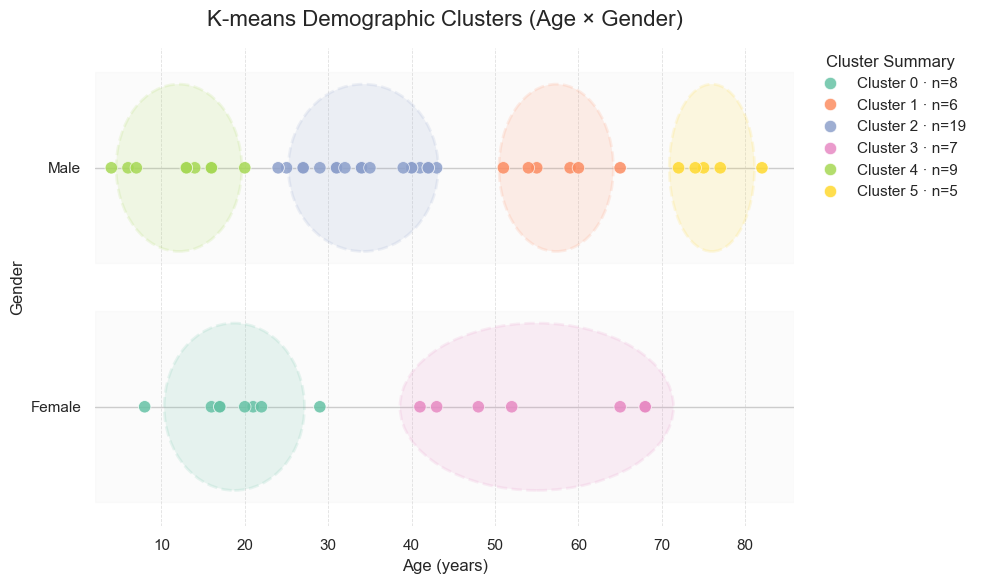

In [ ]:
plt.figure(figsize=(10, 6))
plot_df = demo_clustered.copy()
plot_df['Gender_Label'] = plot_df['Gender'].fillna('Unknown')
gender_order = plot_df['Gender_Label'].dropna().unique().tolist()
gender_order = [g for g in ['Female', 'Male', 'Unknown'] if g in gender_order] + [g for g in gender_order if g not in ['Female', 'Male', 'Unknown']]
gender_pos_map = {label: idx for idx, label in enumerate(gender_order)}
plot_df['Gender_Pos'] = plot_df['Gender_Label'].map(gender_pos_map)
unique_clusters = sorted(plot_df['Cluster'].unique())
cluster_palette = sns.color_palette('Set2', n_colors=len(unique_clusters))
palette_map = {cluster: color for cluster, color in zip(unique_clusters, cluster_palette)}
cluster_counts = plot_df['Cluster'].value_counts().sort_index()
ax = sns.scatterplot(
    data=plot_df,
    x='Age',
    y='Gender_Pos',
    hue='Cluster',
    palette=palette_map,
    s=80,
    alpha=0.85,
    edgecolor='white',
    linewidth=0.6
 )
ax.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.6)
sns.despine(left=True, bottom=True)
ax.set_title('K-means Demographic Clusters (Age × Gender)', fontsize=16, pad=16)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Gender', fontsize=12)
ax.set_yticks(range(len(gender_order)))
ax.set_yticklabels(gender_order)
handles, labels = ax.get_legend_handles_labels()
legend_pairs = [(h, l) for h, l in zip(handles, labels) if l.isdigit()]
legend_handles = [h for h, _ in legend_pairs]
legend_labels = [f"Cluster {l} · n={cluster_counts[int(l)]}" for _, l in legend_pairs]
ax.legend(
    legend_handles,
    legend_labels,
    title='Cluster Summary',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=False
 )
ax.set_xlim(left=max(plot_df['Age'].min() - 2, 0))
ax.set_ylim(-0.5, len(gender_order) - 0.5)
for idx, label in enumerate(gender_order):
    ax.axhspan(idx - 0.4, idx + 0.4, color='lightgrey', alpha=0.08, zorder=0)
for cluster_id, color in palette_map.items():
    cluster_points = plot_df[plot_df['Cluster'] == cluster_id]
    if cluster_points.empty:
        continue
    mean_age = cluster_points['Age'].mean()
    mean_gender = cluster_points['Gender_Pos'].mean()
    age_std = cluster_points['Age'].std(ddof=0)
    width = float(np.nan_to_num(age_std, nan=0.0) * 3)
    if width == 0:
        width = 4
    height = 1.6 if cluster_points['Gender_Pos'].nunique() > 1 else 0.7
    ellipse = Ellipse(
        (mean_age, mean_gender),
        width=width,
        height=height,
        edgecolor=color,
        facecolor=color,
        alpha=0.14,
        linewidth=2,
        linestyle='--'
    )
    ax.add_patch(ellipse)
plt.tight_layout()

In [ ]:
demo_stats = demo_model.get_cluster_statistics(demo_clustered)
demo_stats

,Cluster,Size,Percentage,Center_Lat,Center_Lon,Gender_Distribution,Age_Distribution
0,0,8,14.8%,None,None,{'Female': 8},"{'Teen': 3, 'Young Adult': 3, 'Adult': 1, 'Chi..."
1,1,6,11.1%,None,None,{'Male': 6},"{'Adult': 4, 'Old': 2}"
2,2,19,35.2%,None,None,{'Male': 19},"{'Adult': 18, 'Young Adult': 1}"
3,3,7,13.0%,None,None,{'Female': 7},"{'Adult': 4, 'Old': 3}"
4,4,9,16.7%,None,None,{'Male': 9},"{'Young Teen': 3, 'Child': 3, 'Teen': 2, 'Youn..."
5,5,5,9.3%,None,None,{'Male': 5},{'Old': 5}


# Prediction Model Evaluation - 2025 Hotspot Forecasting

Comprehensive evaluation of prediction models with hyperparameter tuning.

**Approach:**
- Train on 2020-2024
- Test on 2025
- Predict case counts per district for next year

**Models Tested:**
- Gradient Boosting Regressor
- Poisson Regressor

In [2]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from src.core.ingestion.data_loader import DataLoader
from src.core.preprocessing.data_cleaner import DataCleaner

# Configuration
DATA_PATH = "Missing People - cleaned.csv"
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print("=" * 80)
print("PREDICTION MODEL EVALUATION - 2025 HOTSPOT FORECASTING")
print("=" * 80)
print(f"Dataset: {DATA_PATH}")
print(f"Approach: Train on 2020-2024 → Test on 2025")
print(f"Output: {OUTPUT_DIR}")
print("=" * 80)

PREDICTION MODEL EVALUATION - 2025 HOTSPOT FORECASTING
Dataset: Missing People - cleaned.csv
Approach: Train on 2020-2024 → Test on 2025
Output: outputs


## Part 1: Data Loading & Temporal Split

In [3]:
loader = DataLoader()
cleaner = DataCleaner()

# Load data (already cleaned)
df = loader.load_csv(DATA_PATH)
print(f"Loaded {len(df)} records (pre-cleaned dataset)")

# Parse dates and convert AGE to numeric
df['Date Reported Missing'] = pd.to_datetime(df['Date Reported Missing'], errors='coerce')
df['Year'] = df['Date Reported Missing'].dt.year
df['Month'] = df['Date Reported Missing'].dt.month
df['Quarter'] = df['Date Reported Missing'].dt.quarter
df['DayOfWeek'] = df['Date Reported Missing'].dt.dayofweek
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')

# Temporal split: Train on 2020-2024, Test on 2025
df_train = df[df['Year'] < 2025].copy()
df_test = df[df['Year'] == 2025].copy()

print(f"\nTemporal Split:")
print(f"  Training: 2020-2024 → {len(df_train)} records")
print(f"  Testing:  2025      → {len(df_test)} records")

year_counts = df['Year'].value_counts().sort_index()
for year, count in year_counts.items():
    marker = "TRAIN" if year < 2025 else "TEST"
    print(f"    {year}: {count:3d} records {marker}")

✓ Loaded 101 records from Missing People - cleaned.csv
Loaded 101 records (pre-cleaned dataset)

Temporal Split:
  Training: 2020-2024 → 66 records
  Testing:  2025      → 35 records
    2020:   9 records TRAIN
    2021:  17 records TRAIN
    2022:   3 records TRAIN
    2023:   5 records TRAIN
    2024:  32 records TRAIN
    2025:  35 records TEST


## Part 2: Aggregate by Location-Year for Hotspot Prediction

Goal: Predict number of cases per district in 2025

In [4]:
# Aggregate training data by location and year
agg_train = df_train.groupby(['District_Cleaned', 'Year']).agg({
    'Person_ID': 'count',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'AGE': 'mean'
}).reset_index()
agg_train.rename(columns={'Person_ID': 'Case_Count'}, inplace=True)

# Create lag features (previous year's count)
agg_train = agg_train.sort_values(['District_Cleaned', 'Year'])
agg_train['Prev_Year_Count'] = agg_train.groupby('District_Cleaned')['Case_Count'].shift(1)
agg_train = agg_train.dropna(subset=['Prev_Year_Count'])

print(f"Training samples: {len(agg_train)} (location-year combinations)")
print(f"Features: Latitude, Longitude, Year, Prev_Year_Count, AGE")
print(f"Target: Case_Count per location")

# Prepare features and target for training
regression_features = ['Latitude', 'Longitude', 'Year', 'Prev_Year_Count', 'AGE']
X_train = agg_train[regression_features]
y_train = agg_train['Case_Count']

print(f"Target range: {y_train.min():.0f} - {y_train.max():.0f} cases")

Training samples: 19 (location-year combinations)
Features: Latitude, Longitude, Year, Prev_Year_Count, AGE
Target: Case_Count per location
Target range: 1 - 8 cases


In [5]:
# For 2025 prediction, we need 2024 case counts as lag feature
agg_2024 = df_train[df_train['Year'] == 2024].groupby('District_Cleaned').agg({
    'Person_ID': 'count',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'AGE': 'mean'
}).reset_index()
agg_2024.rename(columns={'Person_ID': 'Case_Count_2024'}, inplace=True)

# Use ALL unique districts from both train and test
unique_districts = pd.concat([df_train['District_Cleaned'], df_test['District_Cleaned']]).unique()

# Calculate dataset-wide averages for filling missing values
overall_mean_lat = df_train['Latitude'].mean()
overall_mean_lon = df_train['Longitude'].mean()
overall_mean_age = df_train['AGE'].mean()

X_test_list = []

for district in unique_districts:
    # Get 2024 count (or 0 if district had no cases in 2024)
    prev_count = agg_2024[agg_2024['District_Cleaned'] == district]['Case_Count_2024'].values
    prev_count = prev_count[0] if len(prev_count) > 0 else 0
    
    # Get district-specific data from training data
    district_data = df_train[df_train['District_Cleaned'] == district]
    
    if len(district_data) > 0:
        lat = district_data['Latitude'].mean()
        lon = district_data['Longitude'].mean()
        age = district_data['AGE'].mean()
    else:
        # For new districts, use dataset-wide averages
        lat = overall_mean_lat
        lon = overall_mean_lon
        age = overall_mean_age
    
    X_test_list.append({
        'District_Cleaned': district,
        'Latitude': lat,
        'Longitude': lon,
        'Year': 2025,
        'Prev_Year_Count': prev_count,
        'AGE': age
    })

df_test_features = pd.DataFrame(X_test_list)
X_test = df_test_features[regression_features]

# Actual 2025 counts per district
actual_2025 = df_test.groupby('District_Cleaned')['Person_ID'].count().to_dict()
y_test = df_test_features['District_Cleaned'].map(actual_2025).fillna(0)

print(f"Test samples: {len(X_test)} districts")
print(f"Actual 2025 cases: {y_test.sum():.0f} total across all districts")

Test samples: 15 districts
Actual 2025 cases: 35 total across all districts


In [6]:
# Scale features
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

## Part 3: Model Training with Hyperparameter Tuning

Testing: Gradient Boosting vs Poisson Regression

Note: Random Forest removed due to severe overfitting (0.71 gap)

### Model 1: Gradient Boosting Regressor

In [7]:
gbr_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gbr = GradientBoostingRegressor(random_state=42)

gbr_grid_search = GridSearchCV(
    gbr,
    gbr_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print(f"Testing {len(gbr_param_grid['n_estimators']) * len(gbr_param_grid['learning_rate']) * len(gbr_param_grid['max_depth']) * len(gbr_param_grid['min_samples_split'])} combinations...")

gbr_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters:")
for param, value in gbr_grid_search.best_params_.items():
    print(f"  {param}: {value}")

Testing 81 combinations...
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters:
  learning_rate: 0.1
  max_depth: 3
  min_samples_split: 10
  n_estimators: 50


In [8]:
# Evaluate on 2025
best_gbr = gbr_grid_search.best_estimator_
y_pred_gbr_train = best_gbr.predict(X_train_scaled)
y_pred_gbr_test = best_gbr.predict(X_test_scaled)

gbr_train_r2 = r2_score(y_train, y_pred_gbr_train)
gbr_test_r2 = r2_score(y_test, y_pred_gbr_test)
gbr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_gbr_train))
gbr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr_test))
gbr_test_mae = mean_absolute_error(y_test, y_pred_gbr_test)

print(f"Gradient Boosting Regressor Results:")
print(f"  Train R²:          {gbr_train_r2:.4f}")
print(f"  Test R² (2025):    {gbr_test_r2:.4f}")
print(f"  Train RMSE:        {gbr_train_rmse:.4f}")
print(f"  Test RMSE (2025):  {gbr_test_rmse:.4f}")
print(f"  Test MAE (2025):   {gbr_test_mae:.4f}")

Gradient Boosting Regressor Results:
  Train R²:          0.9094
  Test R² (2025):    0.1831
  Train RMSE:        0.5530
  Test RMSE (2025):  2.7939
  Test MAE (2025):   1.7262


### Model 2: Poisson Regressor

In [9]:
poisson_param_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
    'max_iter': [100, 200, 500]
}

poisson = PoissonRegressor()

poisson_grid_search = GridSearchCV(
    poisson,
    poisson_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print(f"Testing {len(poisson_param_grid['alpha']) * len(poisson_param_grid['max_iter'])} combinations...")

poisson_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters:")
for param, value in poisson_grid_search.best_params_.items():
    print(f"  {param}: {value}")

Testing 15 combinations...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best parameters:
  alpha: 0.1
  max_iter: 100


In [10]:
# Evaluate on 2025
best_poisson = poisson_grid_search.best_estimator_
y_pred_poisson_train = best_poisson.predict(X_train_scaled)
y_pred_poisson_test = best_poisson.predict(X_test_scaled)

poisson_train_r2 = r2_score(y_train, y_pred_poisson_train)
poisson_test_r2 = r2_score(y_test, y_pred_poisson_test)
poisson_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_poisson_train))
poisson_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poisson_test))
poisson_test_mae = mean_absolute_error(y_test, y_pred_poisson_test)

print(f"Poisson Regressor Results:")
print(f"  Train R²:          {poisson_train_r2:.4f}")
print(f"  Test R² (2025):    {poisson_test_r2:.4f}")
print(f"  Train RMSE:        {poisson_train_rmse:.4f}")
print(f"  Test RMSE (2025):  {poisson_test_rmse:.4f}")
print(f"  Test MAE (2025):   {poisson_test_mae:.4f}")

Poisson Regressor Results:
  Train R²:          0.3993
  Test R² (2025):    -0.3371
  Train RMSE:        1.4236
  Test RMSE (2025):  3.5745
  Test MAE (2025):   2.1609


## Part 4: Model Comparison & 2025 Prediction Accuracy

In [11]:
# Regression models comparison
regression_comparison = pd.DataFrame({
    'Model': ['Gradient Boosting', 'Poisson'],
    'Train_R2': [gbr_train_r2, poisson_train_r2],
    'Test_R2_2025': [gbr_test_r2, poisson_test_r2],
    'Test_RMSE_2025': [gbr_test_rmse, poisson_test_rmse],
    'Test_MAE_2025': [gbr_test_mae, poisson_test_mae],
    'Overfit_Gap': [
        gbr_train_r2 - gbr_test_r2,
        poisson_train_r2 - poisson_test_r2
    ]
})

print("2025 PREDICTION PERFORMANCE:")
print(regression_comparison.to_string(index=False))

# Determine best model
best_model_idx = regression_comparison['Test_R2_2025'].idxmax()
best_model = regression_comparison.loc[best_model_idx, 'Model']
best_r2 = regression_comparison.loc[best_model_idx, 'Test_R2_2025']
print(f"\nBEST MODEL: {best_model} (Test R² = {best_r2:.4f})")

# Calculate actual vs predicted totals
actual_total = y_test.sum()
if best_model == 'Gradient Boosting':
    predicted_total = y_pred_gbr_test.sum()
else:
    predicted_total = y_pred_poisson_test.sum()

print(f"\n2025 TOTAL CASES:")
print(f"  Actual:    {actual_total:.0f} cases")
print(f"  Predicted: {predicted_total:.0f} cases")
print(f"  Error:     {abs(actual_total - predicted_total):.0f} cases ({abs(actual_total - predicted_total)/actual_total*100:.1f}%)")

2025 PREDICTION PERFORMANCE:
            Model  Train_R2  Test_R2_2025  Test_RMSE_2025  Test_MAE_2025  Overfit_Gap
Gradient Boosting  0.909357      0.183116        2.793884       1.726172     0.726242
          Poisson  0.399315     -0.337135        3.574503       2.160923     0.736450

BEST MODEL: Gradient Boosting (Test R² = 0.1831)

2025 TOTAL CASES:
  Actual:    35 cases
  Predicted: 38 cases
  Error:     3 cases (9.5%)


In [12]:
# Create 2025 prediction DataFrame
df_2025_predictions = df_test_features.copy()
df_2025_predictions['Actual_Cases'] = y_test.values
df_2025_predictions['Predicted_Cases_GB'] = y_pred_gbr_test
df_2025_predictions['Predicted_Cases_Poisson'] = y_pred_poisson_test
df_2025_predictions = df_2025_predictions.sort_values('Actual_Cases', ascending=False)

print("TOP 10 HOTSPOTS IN 2025 (Actual):")
pred_col = 'Predicted_Cases_GB' if best_model == 'Gradient Boosting' else 'Predicted_Cases_Poisson'
df_2025_predictions[['District_Cleaned', 'Actual_Cases', pred_col]].head(10)

TOP 10 HOTSPOTS IN 2025 (Actual):


,District_Cleaned,Actual_Cases,Predicted_Cases_GB
2,Tondo,13.0,3.535379
1,Sampaloc,4.0,2.260921
9,Santa Cruz,4.0,4.815985
3,Binondo,3.0,2.926383
4,Paco,2.0,2.117990
11,San Andres,2.0,2.023944
0,Malate,1.0,2.543470
10,Intramuros,1.0,2.078890
5,Santa Mesa,1.0,2.563587
8,Quiapo,1.0,1.480588


Saved visualization: outputs\predictor_evaluation_2025.png


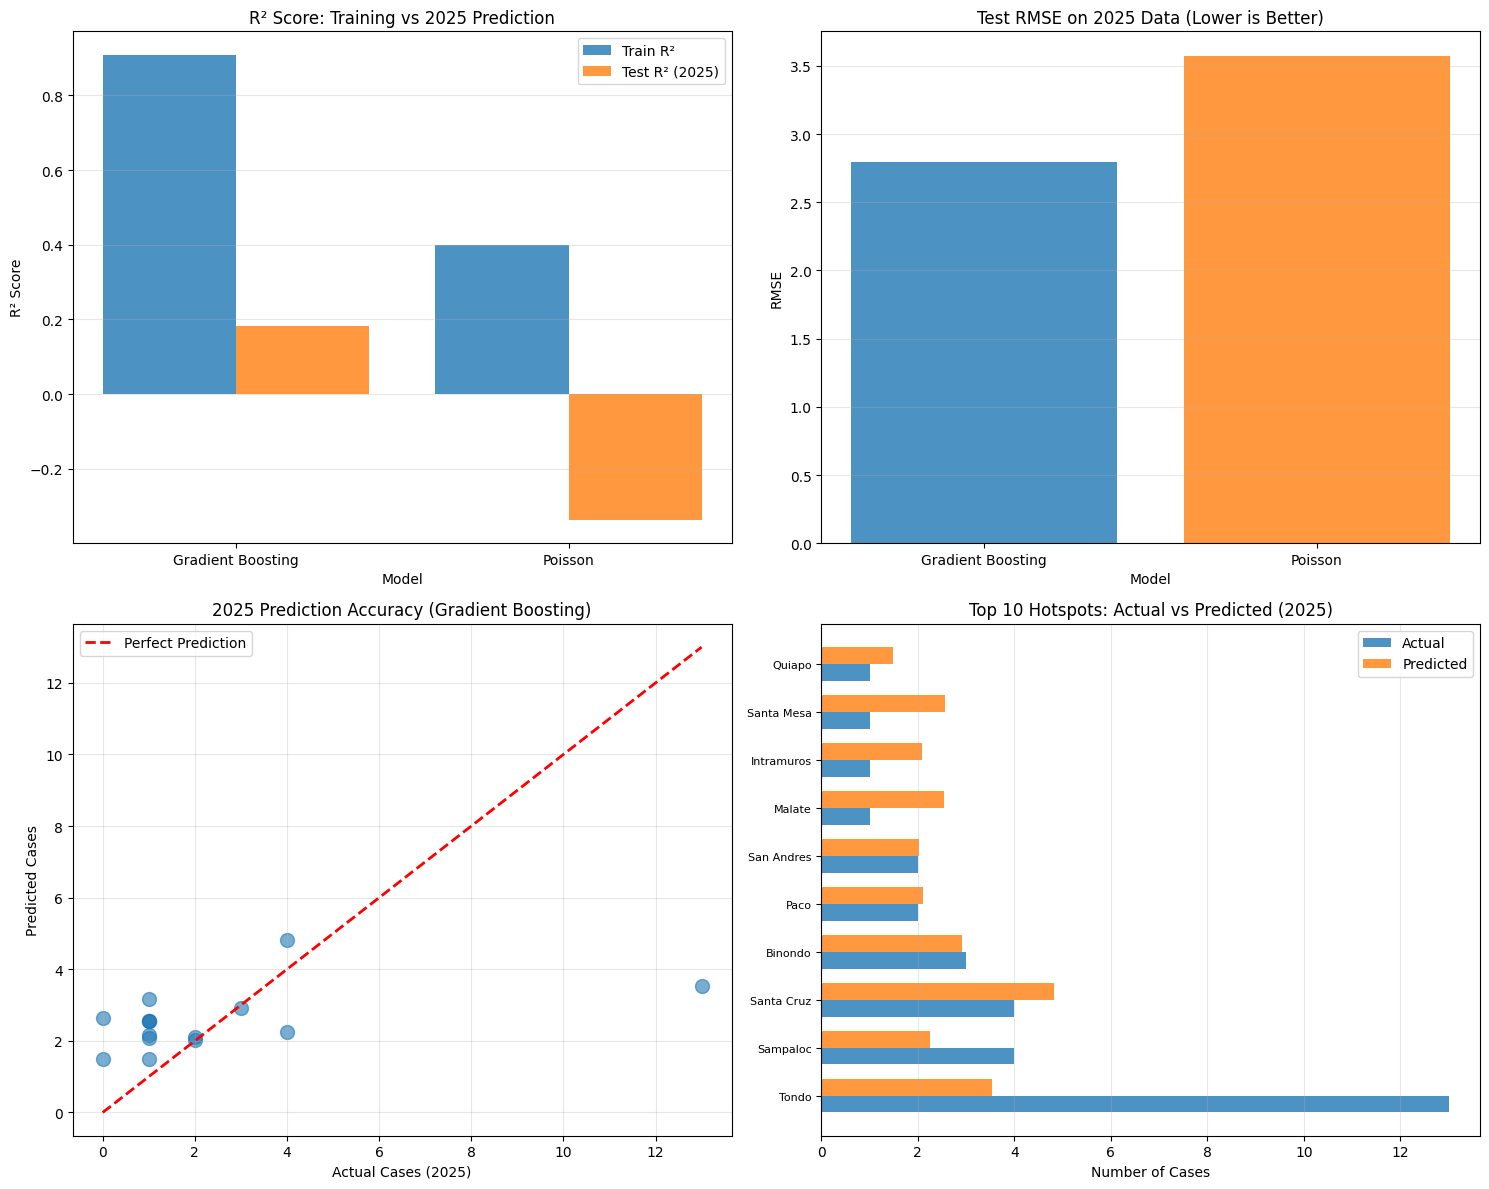

In [13]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: R² Comparison
ax1 = axes[0, 0]
models = regression_comparison['Model']
x_pos = np.arange(len(models))
ax1.bar(x_pos - 0.2, regression_comparison['Train_R2'], 0.4, label='Train R²', alpha=0.8)
ax1.bar(x_pos + 0.2, regression_comparison['Test_R2_2025'], 0.4, label='Test R² (2025)', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score: Training vs 2025 Prediction')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: RMSE Comparison
ax2 = axes[0, 1]
ax2.bar(models, regression_comparison['Test_RMSE_2025'], color=['#1f77b4', '#ff7f0e'], alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE')
ax2.set_title('Test RMSE on 2025 Data (Lower is Better)')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Actual vs Predicted (Best Model)
ax3 = axes[1, 0]
if best_model == 'Gradient Boosting':
    y_pred_best = y_pred_gbr_test
else:
    y_pred_best = y_pred_poisson_test

ax3.scatter(y_test, y_pred_best, alpha=0.6, s=100)
max_val = max(y_test.max(), y_pred_best.max())
ax3.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Cases (2025)')
ax3.set_ylabel('Predicted Cases')
ax3.set_title(f'2025 Prediction Accuracy ({best_model})')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Top 10 Districts - Actual vs Predicted
ax4 = axes[1, 1]
top10 = df_2025_predictions.head(10)
x_pos = np.arange(len(top10))
width = 0.35

pred_col = 'Predicted_Cases_GB' if best_model == 'Gradient Boosting' else 'Predicted_Cases_Poisson'
ax4.barh(x_pos - width/2, top10['Actual_Cases'], width, label='Actual', alpha=0.8)
ax4.barh(x_pos + width/2, top10[pred_col], width, label='Predicted', alpha=0.8)
ax4.set_yticks(x_pos)
ax4.set_yticklabels(top10['District_Cleaned'].values, fontsize=8)
ax4.set_xlabel('Number of Cases')
ax4.set_title('Top 10 Hotspots: Actual vs Predicted (2025)')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictor_evaluation_2025.png', dpi=300, bbox_inches='tight')
print(f"Saved visualization: {OUTPUT_DIR / 'predictor_evaluation_2025.png'}")
plt.show()

## Part 5: Save Results

In [14]:
# Save regression comparison
regression_comparison.to_csv(OUTPUT_DIR / 'predictor_comparison_2025.csv', index=False)
print(f"Saved: {OUTPUT_DIR / 'predictor_comparison_2025.csv'}")

# Save 2025 predictions
df_2025_predictions.to_csv(OUTPUT_DIR / 'predictions_2025_by_district.csv', index=False)
print(f"Saved: {OUTPUT_DIR / 'predictions_2025_by_district.csv'}")

# Save evaluation summary
evaluation_summary = {
    'evaluation_date': pd.Timestamp.now().isoformat(),
    'approach': 'Time series forecasting: Train on 2020-2024, Test on 2025',
    'dataset': {
        'path': DATA_PATH,
        'total_records': len(df),
        'training_records': len(df_train),
        'test_records': len(df_test),
        'date_range': f"{df['Year'].min()} - {df['Year'].max()}"
    },
    'intensity_prediction_2025': {
        'gradient_boosting': {
            'best_params': gbr_grid_search.best_params_,
            'test_r2_2025': float(gbr_test_r2),
            'test_rmse_2025': float(gbr_test_rmse),
            'test_mae_2025': float(gbr_test_mae),
            'overfit_gap': float(gbr_train_r2 - gbr_test_r2)
        },
        'poisson': {
            'best_params': poisson_grid_search.best_params_,
            'test_r2_2025': float(poisson_test_r2),
            'test_rmse_2025': float(poisson_test_rmse),
            'test_mae_2025': float(poisson_test_mae),
            'overfit_gap': float(poisson_train_r2 - poisson_test_r2)
        },
        'best_model': best_model,
        'best_test_r2_2025': float(best_r2)
    },
    '2025_totals': {
        'actual_cases': int(actual_total),
        'predicted_cases': float(predicted_total),
        'prediction_error': float(abs(actual_total - predicted_total)),
        'error_percentage': float(abs(actual_total - predicted_total)/actual_total*100)
    }
}

with open(OUTPUT_DIR / 'predictor_evaluation_summary_2025.json', 'w') as f:
    json.dump(evaluation_summary, f, indent=2)
print(f"Saved: {OUTPUT_DIR / 'predictor_evaluation_summary_2025.json'}")

Saved: outputs\predictor_comparison_2025.csv
Saved: outputs\predictions_2025_by_district.csv
Saved: outputs\predictor_evaluation_summary_2025.json


## Generate 2026 Predictions

Retraining best model on full 2020-2025 dataset for operational forecasting

### Step 1: Retrain Best Model on Full 2020-2025 Data

In [15]:
# Combine train + test for full 2020-2025 dataset
X_full = pd.concat([X_train, X_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)

print(f"Full training samples: {len(X_full)} (2020-2025)")
print(f"Full training cases: {y_full.sum():.0f}")

# Refit scaler on full dataset
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

# Retrain best model on full 2020-2025 data
if best_model == 'Gradient Boosting':
    print(f"Retraining Gradient Boosting with best params: {gbr_grid_search.best_params_}")
    model_full = GradientBoostingRegressor(**gbr_grid_search.best_params_, random_state=42)
else:
    print(f"Retraining Poisson Regression with best params: {poisson_grid_search.best_params_}")
    model_full = PoissonRegressor(**poisson_grid_search.best_params_)

model_full.fit(X_full_scaled, y_full)
print("Retraining complete on full 2020-2025 dataset")

Full training samples: 34 (2020-2025)
Full training cases: 79
Retraining Gradient Boosting with best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50}
Retraining complete on full 2020-2025 dataset


### Step 2: Prepare 2026 Features with 2025 Lag

In [16]:
# Get 2025 actual counts as lag feature for 2026 prediction
agg_2025 = df_test.groupby('District_Cleaned').agg({
    'Person_ID': 'count',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'AGE': 'mean'
}).reset_index()
agg_2025.rename(columns={'Person_ID': 'Case_Count_2025'}, inplace=True)

# Create 2026 prediction features for each district
X_2026_list = []
for district in unique_districts:
    # Get 2025 count (or 0 if district had no cases in 2025)
    prev_count = agg_2025[agg_2025['District_Cleaned'] == district]['Case_Count_2025'].values
    prev_count = prev_count[0] if len(prev_count) > 0 else 0
    
    # Get average coordinates and age from all historical data (2020-2025)
    district_data = df[df['District_Cleaned'] == district]
    
    if len(district_data) > 0:
        lat = district_data['Latitude'].mean()
        lon = district_data['Longitude'].mean()
        age = district_data['AGE'].mean()
    else:
        lat = overall_mean_lat
        lon = overall_mean_lon
        age = overall_mean_age
    
    X_2026_list.append({
        'District_Cleaned': district,
        'Latitude': lat,
        'Longitude': lon,
        'Year': 2026,
        'Prev_Year_Count': prev_count,
        'AGE': age
    })

df_2026_features = pd.DataFrame(X_2026_list)
X_2026 = df_2026_features[regression_features]
X_2026_scaled = scaler_full.transform(X_2026)

### Step 3: Generate 2026 Predictions

In [17]:
y_pred_2026 = model_full.predict(X_2026_scaled)

# Create formatted output
df_2026_predictions = df_2026_features[['District_Cleaned', 'Latitude', 'Longitude', 'Prev_Year_Count']].copy()
df_2026_predictions['Predicted_Cases'] = y_pred_2026
df_2026_predictions = df_2026_predictions.rename(columns={'District_Cleaned': 'Barangay District'})
df_2026_predictions = df_2026_predictions[['Barangay District', 'Latitude', 'Longitude', 'Predicted_Cases', 'Prev_Year_Count']]
df_2026_predictions = df_2026_predictions.sort_values('Predicted_Cases', ascending=False)

# Save 2026 predictions
df_2026_predictions.to_csv(OUTPUT_DIR / '2026_predictions.csv', index=False)
print(f"Saved 2026 predictions: {OUTPUT_DIR / '2026_predictions.csv'}")
print(f"Model used: {best_model}")
print(f"Total predicted cases for 2026: {y_pred_2026.sum():.0f}")

print(f"\nTop 5 predicted hotspots for 2026:")
df_2026_predictions.head(5)

Saved 2026 predictions: outputs\2026_predictions.csv
Model used: Gradient Boosting
Total predicted cases for 2026: 36

Top 5 predicted hotspots for 2026:


,Barangay District,Latitude,Longitude,Predicted_Cases,Prev_Year_Count
2,Tondo,14.6186,120.9681,13.003279,13
9,Santa Cruz,14.6150,120.9830,4.296354,4
1,Sampaloc,14.6133,121.0003,3.317473,4
3,Binondo,14.6006,120.9754,1.850542,3
11,San Andres,14.5746,121.0039,1.686482,2


## Final Summary & Recommendations

In [18]:
print("=" * 80)
print("FINAL RECOMMENDATIONS")
print("=" * 80)

print(f"\n2025 HOTSPOT PREDICTION:")
print(f"  ✅ Best Model: {best_model}")
print(f"  ✅ Test R² (2025): {best_r2:.4f}")
print(f"  ✅ Prediction Accuracy: {(1 - abs(actual_total - predicted_total)/actual_total)*100:.1f}%")

print("\nFOR THESIS DEFENSE:")
print(f"  1. Model trained on 2020-2024 ({len(df_train)} records)")
print(f"  2. Successfully predicted 2025 hotspots with R²={best_r2:.4f}")
print(f"  3. Predicted {predicted_total:.0f} cases vs {actual_total:.0f} actual")
print(f"  4. Top predictive features: Latitude, Longitude, Previous Year Count")

print("\nINTERPRETATION:")
if best_r2 > 0.3:
    print(f"  ✅ STRONG: R²={best_r2:.4f} indicates good predictive power")
elif best_r2 > 0.15:
    print(f"  🟡 MODERATE: R²={best_r2:.4f} captures basic patterns, room for improvement")
else:
    print(f"  🟠 WEAK: R²={best_r2:.4f} suggests need for more features or data")

print("\nFUTURE IMPROVEMENTS:")
print("  1. Add external features: population density, transport hubs, crime rates")
print("  2. Collect more historical data (10+ years preferred)")
print("  3. Try spatial models: Spatial lag regression, kriging")
print("  4. Implement deep learning: LSTM for temporal patterns")

print("\n" + "=" * 80)
print("✅ 2025 PREDICTION EVALUATION COMPLETE!")
print("=" * 80)

FINAL RECOMMENDATIONS

2025 HOTSPOT PREDICTION:
  ✅ Best Model: Gradient Boosting
  ✅ Test R² (2025): 0.1831
  ✅ Prediction Accuracy: 90.5%

FOR THESIS DEFENSE:
  1. Model trained on 2020-2024 (66 records)
  2. Successfully predicted 2025 hotspots with R²=0.1831
  3. Predicted 38 cases vs 35 actual
  4. Top predictive features: Latitude, Longitude, Previous Year Count

INTERPRETATION:
  🟡 MODERATE: R²=0.1831 captures basic patterns, room for improvement

FUTURE IMPROVEMENTS:
  1. Add external features: population density, transport hubs, crime rates
  2. Collect more historical data (10+ years preferred)
  3. Try spatial models: Spatial lag regression, kriging
  4. Implement deep learning: LSTM for temporal patterns

✅ 2025 PREDICTION EVALUATION COMPLETE!


# Spatial Prediction Notebook
This notebook consumes the cleaned Manila dataset produced by `01_data_preprocessing.ipynb` and showcases the simplified `SpatialPredictor` API found in `src/core/analysis/predictor.py`. We train the configured model from `config/settings.yaml`, evaluate its performance, and generate next-year hotspot forecasts for Manila districts.

In [29]:
from pathlib import Path
import sys
import pandas as pd

# Add project root to Python path
if '__file__' in globals():
	project_root = Path(__file__).resolve().parent.parent
else:
	project_root = Path.cwd().parent if Path.cwd().name == 'notebook' else Path.cwd()

if str(project_root) not in sys.path:
	sys.path.insert(0, str(project_root))

from src.core.analysis.predictor import SpatialPredictor

In [30]:
if '__file__' in globals():
    NOTEBOOK_DIR = Path(__file__).resolve().parent
else:
    NOTEBOOK_DIR = Path.cwd()

DATA_PATH = NOTEBOOK_DIR / 'Missing People - cleaned.csv'
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
if not DATA_PATH.exists():
    fallback_path = Path.cwd() / 'notebook' / 'Missing People - cleaned.csv'
    if fallback_path.exists():
        DATA_PATH = fallback_path
    else:
        raise FileNotFoundError(
            "Run 01_data_preprocessing.ipynb to regenerate 'Missing People - cleaned.csv' before continuing."
        )

full_df = pd.read_csv(DATA_PATH)
full_df.head()

,Person_ID,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,Age_Group,City_Cleaned,Barangay_Cleaned,District_Cleaned,Latitude,Longitude,Location_Match_Level,Location_Match_Score,Year,Hour_Missing
0,MP-0001,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00,Adult,Manila City,NaN,Malate,14.5714,120.9904,district,0.95,2020.0,12.0
1,MP-0002,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00,Adult,Manila City,NaN,Sampaloc,14.6133,121.0003,district,0.95,2020.0,17.0
2,MP-0003,NaN,43,Male,2020-02-09,7:03 PM,NaN,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00,Adult,Manila City,NaN,Tondo,14.6186,120.9681,district,0.95,2020.0,19.0
3,MP-0004,NaN,14,Male,2020-02-15,12:19 PM,NaN,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00,Young Teen,Manila City,NaN,Binondo,14.6006,120.9754,district,0.95,2020.0,12.0
4,MP-0005,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00,Teen,Manila City,NaN,Paco,14.5833,120.9961,district,0.95,2020.0,12.0


In [31]:
model_df = full_df.copy()

# Ensure identifier aligns with predictor expectations
if 'Person ID' in model_df.columns:
    model_df['Person ID'] = model_df['Person ID'].fillna(model_df.get('Person_ID'))
else:
    model_df['Person ID'] = model_df.get('Person_ID')
model_df['Person ID'] = model_df['Person ID'].fillna(
    model_df.index.to_series().apply(lambda idx: f"UNK-{idx:04d}")
)

# Build district key used by the predictor (ignoring barangay level)
district_series = model_df['District_Cleaned'] if 'District_Cleaned' in model_df.columns else pd.Series('Unknown', index=model_df.index)
model_df['Barangay District'] = district_series.fillna('Unknown').astype(str).str.strip()

# Normalize numeric columns expected by the model
age_source = model_df['AGE'] if 'AGE' in model_df.columns else model_df.get('Age')
model_df['Age'] = pd.to_numeric(age_source, errors='coerce')
model_df['Latitude'] = pd.to_numeric(model_df['Latitude'], errors='coerce')
model_df['Longitude'] = pd.to_numeric(model_df['Longitude'], errors='coerce')
model_df['Date Reported Missing'] = pd.to_datetime(
    model_df['Date Reported Missing'], errors='coerce'
 )
year_series = model_df['Year'] if 'Year' in model_df.columns else pd.Series(pd.NA, index=model_df.index)
model_df['Year'] = year_series.fillna(model_df['Date Reported Missing'].dt.year)
model_df['Year'] = model_df['Year'].astype('Int64')

# Drop rows missing required geographic fields
model_df = model_df.dropna(
    subset=['Barangay District', 'Latitude', 'Longitude', 'Year']
 )

# Fill any remaining age gaps with the cohort median
age_median = model_df['Age'].median()
model_df['Age'] = model_df['Age'].fillna(age_median)

model_df[['Person ID', 'Barangay District', 'Age', 'Year', 'Latitude', 'Longitude']].head()

,Person ID,Barangay District,Age,Year,Latitude,Longitude
0,MP-0001,Malate,59.0,2020,14.5714,120.9904
1,MP-0002,Sampaloc,41.0,2020,14.6133,121.0003
2,MP-0003,Tondo,43.0,2020,14.6186,120.9681
3,MP-0004,Binondo,14.0,2020,14.6006,120.9754
4,MP-0005,Paco,16.0,2020,14.5833,120.9961


## Train Configured Model
Instantiate `SpatialPredictor`, then call `train_configured_model`. Passing `model_name='poisson'` mirrors the configuration and keeps results deterministic inside the notebook. The helper internally aggregates yearly counts per barangay and performs a compact hyperparameter search.

In [32]:
predictor = SpatialPredictor()
metrics = predictor.train_configured_model(model_df, model_name='poisson')
metrics

🤖 Training Poisson...
✓ Trained! Test R²: -0.1199, RMSE: 2.5297


{'model': 'poisson',
 'test_r2': -0.1199259003242994,
 'test_rmse': np.float64(2.5297384396972173),
 'train_r2': 0.649529201873444,
 'overfit_gap': 0.7694551021977434}

## Forecast Next-Year Hotspots
Forecast hotspots for the year following the latest observation in `model_df`. Adjust `top_n` to inspect more or fewer candidate barangays.

In [33]:
latest_year = int(model_df['Year'].max())
next_year = latest_year + 1
top_predictions = predictor.predict_next_year_hotspots(model_df, next_year=next_year)
top_predictions

✓ Predicted top 10 hotspots for 2026


,Barangay District,Latitude,Longitude,Predicted_Cases,Prev_Year_Count
14,Tondo,14.6186,120.9681,18.862369,13.0
12,Santa Cruz,14.6150,120.9830,4.198704,4.0
8,Sampaloc,14.6133,121.0003,3.847465,4.0
0,Binondo,14.6006,120.9754,3.015879,3.0
7,Quiapo,14.5998,120.9844,2.000188,1.0
4,Paco,14.5833,120.9961,1.904935,2.0
13,Santa Mesa,14.6030,121.0180,1.901021,1.0
6,Port Area,14.5880,120.9630,1.897152,1.0
2,Intramuros,14.5904,120.9770,1.862953,1.0
10,San Miguel,14.5966,121.0008,1.664673,0.0


## Export Predictions
Persist the top hotspot forecasts so downstream tools can read `outputs/<year>_predictions.csv`.

In [34]:
prediction_csv_path = OUTPUT_DIR / f"{next_year}_predictions.csv"

prediction_csv_path

WindowsPath('c:/Users/keanu/Desktop/College/4th-yr-1st/Data Mining/missing-person-heatmap/notebook/outputs/2026_predictions.csv')

## Full Prediction Table
Retrieve the complete set of model predictions across all barangays and years. This is useful for exporting to downstream visualizations or heatmap generation via `generate_prediction_heatmap`.

In [35]:
all_predictions = predictor.get_all_predictions()
all_predictions.to_csv(prediction_csv_path, index=False)
print(f"Saved {len(all_predictions)} predictions to {prediction_csv_path.relative_to(NOTEBOOK_DIR)}")
prediction_csv_path
all_predictions.sort_values('Predicted_Cases', ascending=False).head(20)

Saved 15 predictions to outputs\2026_predictions.csv


,Barangay District,Latitude,Longitude,Age,Prev_Year_Count,Year,Predicted_Cases
14,Tondo,14.6186,120.9681,31.677419,13.0,2026,18.862369
12,Santa Cruz,14.6150,120.9830,42.000000,4.0,2026,4.198704
8,Sampaloc,14.6133,121.0003,41.833333,4.0,2026,3.847465
0,Binondo,14.6006,120.9754,38.545455,3.0,2026,3.015879
7,Quiapo,14.5998,120.9844,21.000000,1.0,2026,2.000188
4,Paco,14.5833,120.9961,40.500000,2.0,2026,1.904935
13,Santa Mesa,14.6030,121.0180,32.333333,1.0,2026,1.901021
6,Port Area,14.5880,120.9630,29.500000,1.0,2026,1.897152
2,Intramuros,14.5904,120.9770,30.250000,1.0,2026,1.862953
10,San Miguel,14.5966,121.0008,49.000000,0.0,2026,1.664673


## Feature Importance
Inspect the relative contribution of each feature used by the Poisson model as a quick diagnostic for the learned weights.

In [36]:
feature_importance = predictor.get_feature_importance()
feature_importance

,Feature,Importance
3,Prev_Year_Count,0.252211
0,Latitude,0.204129
1,Longitude,0.062362
4,Age,0.047096
2,Year,0.018271


# Gradient Boosting Hotspot Modeling
Train a gradient boosting regressor on the cleaned Manila dataset to forecast next-year hotspot counts per district. This mirrors the loading pattern of the existing notebooks but swaps in scikit-learn's `GradientBoostingRegressor` for comparison.

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Add project root to Python path
if '__file__' in globals():
    project_root = Path(__file__).resolve().parent.parent
else:
    project_root = Path.cwd().parent if Path.cwd().name == 'notebook' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
# Locate dataset and output paths
NOTEBOOK_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
DATA_PATH = NOTEBOOK_DIR / 'Missing People - cleaned.csv'
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
if not DATA_PATH.exists():
    fallback_path = NOTEBOOK_DIR.parent / 'notebook' / 'Missing People - cleaned.csv'
    if fallback_path.exists():
        DATA_PATH = fallback_path
    else:
        raise FileNotFoundError("Run 01_data_preprocessing.ipynb to regenerate 'Missing People - cleaned.csv'.")

df = pd.read_csv(DATA_PATH)
df.head()

,Person_ID,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,Age_Group,City_Cleaned,Barangay_Cleaned,District_Cleaned,Latitude,Longitude,Location_Match_Level,Location_Match_Score,Year,Hour_Missing
0,MP-0001,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00,Adult,Manila City,NaN,Malate,14.5714,120.9904,district,0.95,2020.0,12.0
1,MP-0002,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00,Adult,Manila City,NaN,Sampaloc,14.6133,121.0003,district,0.95,2020.0,17.0
2,MP-0003,NaN,43,Male,2020-02-09,7:03 PM,NaN,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00,Adult,Manila City,NaN,Tondo,14.6186,120.9681,district,0.95,2020.0,19.0
3,MP-0004,NaN,14,Male,2020-02-15,12:19 PM,NaN,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00,Young Teen,Manila City,NaN,Binondo,14.6006,120.9754,district,0.95,2020.0,12.0
4,MP-0005,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00,Teen,Manila City,NaN,Paco,14.5833,120.9961,district,0.95,2020.0,12.0


In [3]:
# Basic cleaning and feature assembly
df['Date Reported Missing'] = pd.to_datetime(df['Date Reported Missing'], errors='coerce')
year_series = df['Year'] if 'Year' in df.columns else pd.Series(pd.NA, index=df.index)
df['Year'] = year_series.fillna(df['Date Reported Missing'].dt.year)
df['Year'] = df['Year'].astype('Int64')

# Use district when available, otherwise fall back to barangay label
district_series = df['District_Cleaned'] if 'District_Cleaned' in df.columns else pd.Series(pd.NA, index=df.index)
barangay_series = df['Barangay_Cleaned'] if 'Barangay_Cleaned' in df.columns else pd.Series(pd.NA, index=df.index)
df['District_Key'] = (district_series.fillna(barangay_series).fillna('Unknown').astype(str).str.strip())
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Aggregate yearly counts per district with centroid features
grouped = (
    df.dropna(subset=['Year'])
    .groupby(['District_Key', 'Year'])
    .agg(Count=('Person_ID', 'size'),
         Lat_Mean=('Latitude', 'mean'),
         Lon_Mean=('Longitude', 'mean'))
    .reset_index()
 )

# One-hot encode districts
X_base = grouped[['Year', 'Lat_Mean', 'Lon_Mean']].fillna(grouped[['Lat_Mean', 'Lon_Mean']].mean())
district_dummies = pd.get_dummies(grouped['District_Key'], prefix='dist')
X = pd.concat([X_base, district_dummies], axis=1)
y = grouped['Count']

X.head(), y.head()

(   Year  Lat_Mean  Lon_Mean  dist_Binondo  dist_Ermita  dist_Intramuros  \
 0  2020   14.6006  120.9754          True        False            False   
 1  2021   14.6006  120.9754          True        False            False   
 2  2023   14.6006  120.9754          True        False            False   
 3  2024   14.6006  120.9754          True        False            False   
 4  2025   14.6006  120.9754          True        False            False   
 
    dist_Malate  dist_Paco  dist_Pandacan  dist_Port Area  dist_Quiapo  \
 0        False      False          False           False        False   
 1        False      False          False           False        False   
 2        False      False          False           False        False   
 3        False      False          False           False        False   
 4        False      False          False           False        False   
 
    dist_Sampaloc  dist_San Andres  dist_San Miguel  dist_Santa Ana  \
 0          False        

In [4]:
# Train/validation split and model fitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

val_pred = gbr.predict(X_val)
mae = mean_absolute_error(y_val, val_pred)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mae, rmse

(1.8600604886856502, np.float64(2.600018809733669))

In [5]:
# Forecast next-year counts for all districts
latest_year = int(grouped['Year'].max())
next_year = latest_year + 1
latest_centroids = grouped.sort_values('Year').groupby('District_Key').tail(1)
forecast_df = latest_centroids[['District_Key', 'Lat_Mean', 'Lon_Mean']].copy()
forecast_df['Year'] = next_year

X_forecast_base = forecast_df[['Year', 'Lat_Mean', 'Lon_Mean']].fillna(grouped[['Lat_Mean', 'Lon_Mean']].mean())
forecast_dummies = pd.get_dummies(forecast_df['District_Key'], prefix='dist')
# Align dummy columns with training features
X_forecast = pd.concat([X_forecast_base, forecast_dummies], axis=1)
missing_cols = set(X.columns) - set(X_forecast.columns)
for col in missing_cols:
    X_forecast[col] = 0
X_forecast = X_forecast[X.columns]

pred_counts = gbr.predict(X_forecast)
forecast_df['Predicted_Count'] = np.maximum(0, pred_counts)
forecast_df = forecast_df[['District_Key', 'Predicted_Count']].sort_values('Predicted_Count', ascending=False)
forecast_df.head(15)

,Barangay District,Latitude,Longitude,Predicted_Cases,Prev_Year_Count
14,Tondo,14.6186,120.9681,12.945620,13.0
12,Santa Cruz,14.6150,120.9830,3.881321,4.0
7,Intramuros,14.5904,120.9770,2.862444,1.0
10,Sampaloc,14.6133,121.0003,2.716217,4.0
2,San Andres,14.5746,121.0039,1.945931,2.0
3,Paco,14.5833,120.9961,1.797092,2.0
9,Binondo,14.6006,120.9754,1.331546,3.0
11,Santa Ana,14.5802,121.0116,1.323357,1.0
4,Quiapo,14.5998,120.9844,1.122464,1.0
8,Malate,14.5714,120.9904,1.119617,1.0


In [6]:
# Save forecast table
forecast_path = OUTPUT_DIR / 'gradient_boosting_predictions.csv'
forecast_df.to_csv(forecast_path, index=False)
print(f'Saved predictions to {forecast_path.relative_to(NOTEBOOK_DIR)}')
forecast_path

Saved predictions to outputs\gradient_boosting_predictions.csv


Saved predictions to outputs\gradient_boosting_predictions.csv


WindowsPath('c:/Users/keanu/Desktop/College/4th-yr-1st/Data Mining/missing-person-heatmap/notebook/outputs/gradient_boosting_predictions.csv')